In [1]:
import kwant
import numpy as np
from cmath import exp
from math import pi, sqrt, tanh
# For plotting
# %run matplotlib_setup.ipy
import matplotlib.pyplot as plt
from ipywidgets import interact
import time
import sys
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

In [219]:
# zigzag edges

t=1.0
t_sc=1.0

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])



def make_system(W=200, L=200, mu=0.6, phi=0):

            
    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        # modulated hopping in y direction # does not work with vortex
#         H1=tinyarray.array([[-t*exp(1j * pi* phi * (xi + xj) * (yi - yj)),0],\
#                             [0,t*exp(-1j * pi* phi * (xi + xj) * (yi - yj))]])
#         # modulated hopping in x direction
        return -t*exp(-1j * pi* phi * (xi - xj) * (yi + yj))
    
    def onsite(site, mu):
        return  - mu

    
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)],
                                     [(0, 0), (0, 1 / sqrt(3))],norbs=1)
    subA, subB = graphene.sublattices
    syst = kwant.Builder()
    syst[(subA(0,y) for y in range(L+1))] = onsite
    syst[(subB(0,y) for y in range(-1,L))] = onsite
    syst[graphene.neighbors()] = hopping_ab


    sym_left = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    left_lead = kwant.Builder(sym_left)
# #     left_lead[lat.shape(lead_slab, (0,0))] = onsite
#     L_lead=int(W/(sqrt(3)/2))
    left_lead[(subA(0,y) for y in range(L+1))] = onsite
    left_lead[(subB(0,y) for y in range(-1,L))] = onsite
    left_lead[graphene.neighbors()] = hopping_ab
    syst.attach_lead(left_lead)
#     syst.attach_lead(left_lead.reversed())

#     a0=3/(4*sqrt(3))
#     b0=0.5
#     primitive_vectors = [(b0, 0), (0, a0)]
#     lat_sc = kwant.lattice.Monatomic(primitive_vectors, offset=(0, a0/6),norbs=4)
    
            
#     # leads
#     def onsite_lead(site, mu_lead):
#         return  (- mu_lead + 4 * t)* np.kron(tau_z,np.eye(2))

#     def hopping_lead(site1, site2):
#         return -t*np.kron(tau_z,np.eye(2))

#     # Manually attach sites from graphene to square lattice
#     Wsys=int(W/a0)
#     Lsys=int(L/b0)
#     syst[(lat_sc(-1, i) for i in range(Wsys))] = onsite_lead
#     syst[((lat_sc(-1, i), lat_sc(-1, i+1)) for i in range(Wsys-1))] = hopping_lead
#     syst[((lat_sc(-1, 2*i), subA(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[((lat_sc(-1, 2*i+1), subB(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[(lat_sc(Lsys, i) for i in range(Wsys))] = onsite_lead
#     syst[((lat_sc(Lsys, i), lat_sc(Lsys, i+1)) for i in range(Wsys-1))] = hopping_lead
#     syst[((lat_sc(Lsys, 2*i), subA(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[((lat_sc(Lsys, 2*i+1), subB(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead

#     claw=-np.kron(np.eye(2),tau_z)
#     sym_left = kwant.TranslationalSymmetry(lat_sc.vec((-1, 0)))
#     left_lead = kwant.Builder(sym_left, conservation_law=claw, particle_hole=np.kron(tau_x,np.eye(2)) )
#     left_lead[(lat_sc(0,y) for y in range(Wsys))] = onsite_lead
#     left_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_ab
#     left_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_ab
#     syst.attach_lead(left_lead)
#     syst.attach_lead(left_lead.reversed())

    
    return syst

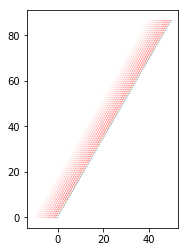

In [220]:
# Wsc must be multiples of eight
W=10
L=100
syst = make_system(W=W, L=L)
# Check that the system looks as intended.
# kwant.plot(syst, colorbar=False,fig_size=(40,80))
kwant.plot(syst,num_lead_cells=10)
# Finalize the system.
syst = syst.finalized()

In [187]:
mu=0.0
phi=0.05
momenta = [-pi + 0.02 * pi * i for i in range(101)]
def plot_wf(phi=0):
    params=dict(mu=mu, phi=phi, momenta=momenta)
    fig = plt.figure()  # create a figure object
    ax1 = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    kwant.plotter.bands(syst.leads[0],params=params,ax=ax1)
    ax1.set_ylim(-2,2)
    plt.show()
    
interact(plot_wf, phi=(0, 0.1, 0.002));

interactive(children=(FloatSlider(value=0.0, description='phi', max=0.1, step=0.002), Output()), _dom_classes=…

In [243]:
# armchair edges

t=1.0
t_sc=1/2

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])


def make_system(Delta=0.2, gn=0.0, gs=0.0, lam=0.0,
                W=200, L=200, Lsc=20, t_j=0.1, mu=0.6, mu_sc=2,mu_lead=0.6, phi=0):

            
    def qh_slab(pos):
        (x, y) = pos 
        return (0 <= x < L) and (0 <= y < W)

    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
#         # modulated hopping in x direction
        H1s=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj)),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj))]])
        H1=np.kron(H1s,np.eye(2))
        return H1

    def onsite(site, mu, gn):
        return  - mu* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(sqrt(3), 0), (0, 1)],
                                [(0, 0), (1/sqrt(3), 0), (3/sqrt(3)/2, 1/2),(5/sqrt(3)/2, 1/2)],norbs=4)
    subA1, subB1,subA2, subB2 = lat.sublattices
    syst = kwant.Builder()
    syst[lat.shape(qh_slab, (0,0))] = onsite
    syst[lat.neighbors()] = hopping_ab

    def hopping_jn(site_i, site_j, t_j):
        return -t_j*np.kron(tau_z,np.eye(2))

    # sc part
    def onsite_sc(site, mu_sc, gs, Delta):
        return  (- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2))\
                + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)

    def hopping_sc(site1, site2,lam):
        h1=-t_sc* np.kron(tau_z,np.eye(2))
        xi, yi = site1.pos
        xj, yj = site2.pos
        if np.abs(xj-xi)>0:
            h2=1j*lam* np.kron(tau_z,tau_y)
        else:
            h2=1j*lam* np.kron(np.eye(2),tau_x)
        return h1+h2
    
    a0=3/(4*sqrt(3))
    b0=0.5
    primitive_vectors = [(a0, 0), (0, b0)]
    lat_sc = kwant.lattice.Monatomic(primitive_vectors, offset=(a0/6,0),norbs=4)

    Lsq=int(L/a0)
    syst[(lat_sc(x,y) for x in range(Lsq) for y in range(-Lsc,0))] = onsite_sc
    syst[((lat_sc(4*i,-1), subA1(i,0)) for i in range(int(Lsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+1,-1), subB1(i,0)) for i in range(int(Lsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+2,-1), subA2(i,0)) for i in range(int(Lsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+3,-1), subB2(i,0)) for i in range(int(Lsq/4)))] = hopping_jn


    sym_right = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    right_lead = kwant.Builder(sym_right)
    right_lead[lat.shape(qh_slab, (0,0))] = onsite
    right_lead[lat.neighbors()] = hopping_ab
    
    right_lead[(lat_sc(x,y) for x in range(4) for y in range(-Lsc,0))] = onsite_sc
    right_lead[(lat_sc(0,-1), subA1(0,0))] = hopping_jn
    right_lead[(lat_sc(1,-1), subB1(0,0))] = hopping_jn
    right_lead[(lat_sc(2,-1), subA2(0,0))] = hopping_jn
    right_lead[(lat_sc(3,-1), subB2(0,0))] = hopping_jn
    right_lead[(lat_sc(0,-Lsc), subA1(0,W-1))] = hopping_jn
    right_lead[(lat_sc(1,-Lsc), subB1(0,W-1))] = hopping_jn
    right_lead[(lat_sc(2,-Lsc), subA2(0,W-1))] = hopping_jn
    right_lead[(lat_sc(3,-Lsc), subB2(0,W-1))] = hopping_jn
    right_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
    right_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc


    syst.attach_lead(right_lead)
#     syst.attach_lead(left_lead.reversed())

     # leads
#     def onsite_lead(site, mu_lead):
#         return  (- mu_lead + 4 * t)* np.kron(tau_z,np.eye(2))

#     def hopping_lead(site1, site2):
#         return -t*np.kron(tau_z,np.eye(2))

    # Manually attach sites from graphene to square lattice
#     Wsys=int(W/a0)
#     Lsys=int(L/b0)
#     syst[(lat_sc(-1, i) for i in range(Wsys))] = onsite_lead
#     syst[((lat_sc(-1, i), lat_sc(-1, i+1)) for i in range(Wsys-1))] = hopping_lead
#     syst[((lat_sc(-1, 2*i), subA(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[((lat_sc(-1, 2*i+1), subB(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[(lat_sc(Lsys, i) for i in range(Wsys))] = onsite_lead
#     syst[((lat_sc(Lsys, i), lat_sc(Lsys, i+1)) for i in range(Wsys-1))] = hopping_lead
#     syst[((lat_sc(Lsys, 2*i), subA(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[((lat_sc(Lsys, 2*i+1), subB(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead

#     claw=-np.kron(np.eye(2),tau_z)
#     sym_left = kwant.TranslationalSymmetry(lat_sc.vec((-1, 0)))
#     left_lead = kwant.Builder(sym_left, conservation_law=claw, particle_hole=np.kron(tau_x,np.eye(2)) )
#     left_lead[(lat_sc(0,y) for y in range(Wsys))] = onsite_lead
#     left_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_ab
#     left_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_ab
#     syst.attach_lead(left_lead)
#     syst.attach_lead(left_lead.reversed())

    
    return syst

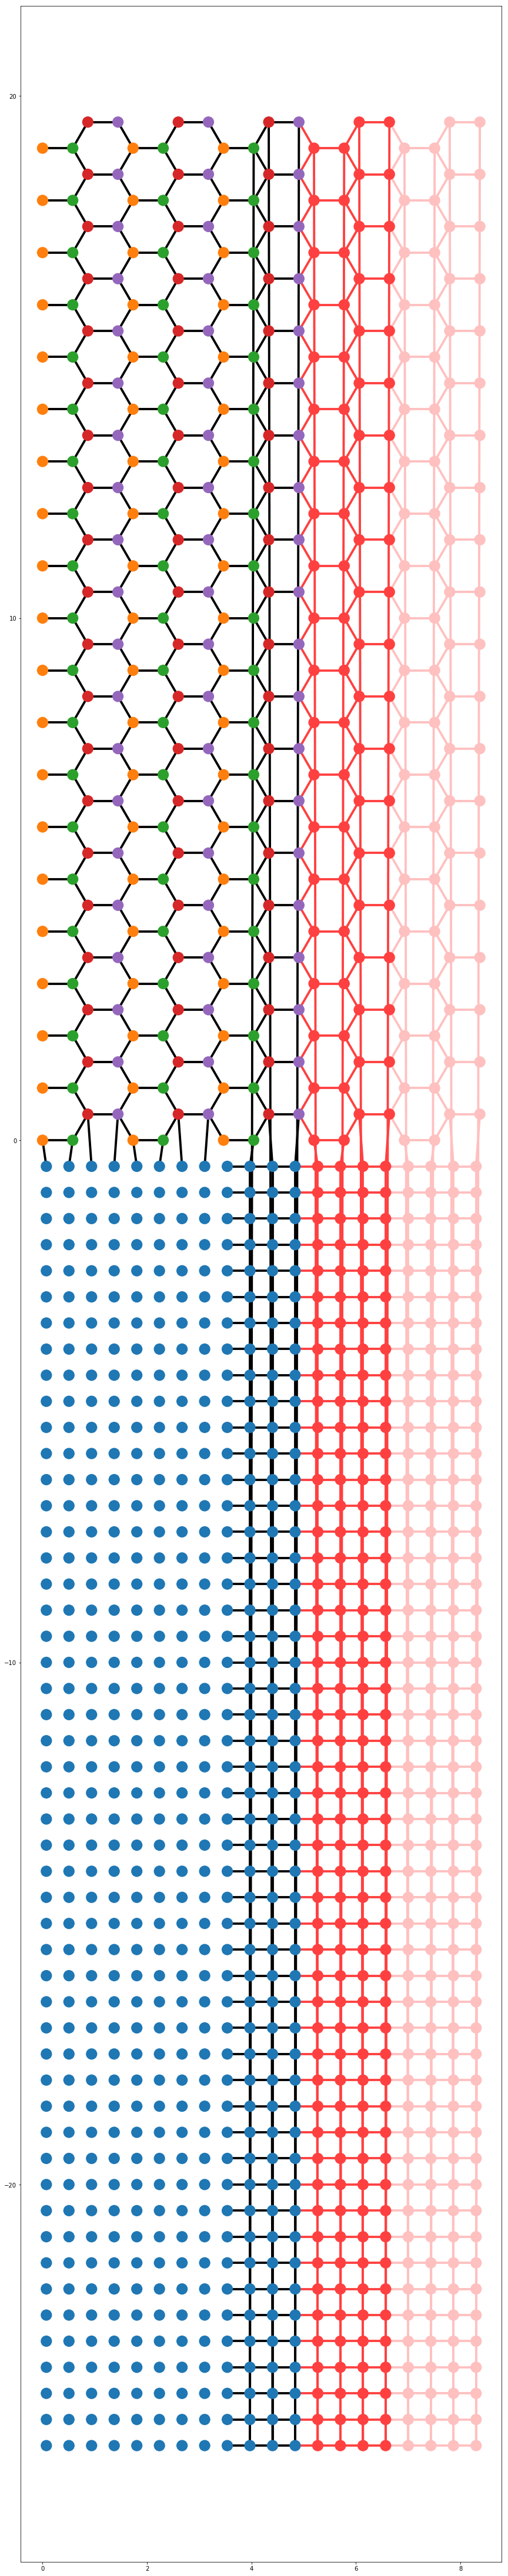

In [244]:
# Wsc must be multiples of eight
W=100
L=4
Lsc=50
syst = make_system(W=W, L=L, Lsc=Lsc)
# Check that the system looks as intended.
kwant.plot(syst, colorbar=False,fig_size=(40,80),num_lead_cells=2)
# kwant.plot(syst,num_lead_cells=2)
# Finalize the system.
syst = syst.finalized()

In [245]:
mu=0.145
mu_sc= mu+ t
Delta=0.03
t_j=1.0
gs=0.
gn=0.
lam=0.0
phi=0.0095

momenta = [(-pi + 0.01 * pi * i) for i in range(201)]

# # def plot_wf(phi=0.03):
# params=dict(t_j=t_j, gn=gn, lam=lam, gs=gs, Delta=Delta, mu=mu ,mu_sc=mu_sc,phi=phi,momenta=momenta)
# fig = plt.figure()  # create a figure object
# ax1 = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
# kwant.plotter.bands(syst.leads[0],params=params,ax=ax1)
# ax1.set_ylim(-0.06,0.06)
# #     ax1.set_xlim(-3,-1)
# plt.show()
    
# # interact(plot_wf, phi=(0, 0.1, 0.002));
# # plot_wf(phi=0.0095*4.5)

params=dict(t_j=t_j, gn=gn, lam=lam, gs=gs, Delta=Delta, mu=mu ,mu_sc=mu_sc,phi=phi)
bands = kwant.physics.Bands(syst.leads[0], params=params)
energies = [bands(k) for k in momenta]

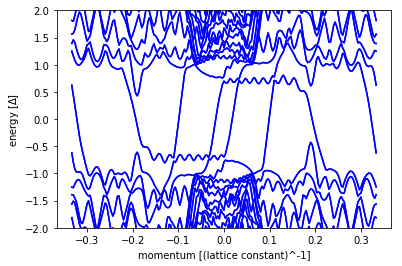

In [246]:
plt.figure()
plt.plot(np.array(momenta)/3/pi, np.array(energies)/Delta,'b')
# plt.plot((momenta), (energies))
plt.ylim(-2,2)
plt.xlabel("momentum [(lattice constant)^-1]")
plt.ylabel(r"energy [$\Delta$]")
plt.show()